In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
import os
drive.mount('/content/drive')

Mounted at /content/drive


# Data Prep

loading csv files from google drive

In [3]:
directory = '/content/drive/My Drive/NBA Season Data/2016-17'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

In [4]:
files.keys()

dict_keys(['post_up', 'assists', 'box_scores', 'cut', 'hand_off', 'height_weight', 'putback', 'pnr_handler', 'off_screen', 'touches', 'screen_assists', 'drives', 'pnr_man', 'isolation', 'shot_chart', 'catch_and_shoot', 'spot_up'])

In [5]:
for name in files.keys():
  print(f"STAT: {name}")
  files[name].info()
  print()

STAT: post_up
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PLAYER    486 non-null    object 
 1   TEAM      486 non-null    object 
 2   POST UPS  486 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.5+ KB

STAT: assists
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PLAYER       486 non-null    object 
 1   TEAM         486 non-null    object 
 2   PASSES MADE  486 non-null    float64
dtypes: float64(1), object(2)
memory usage: 11.5+ KB

STAT: box_scores
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PLAYER  486 non-null    object 
 1   TEAM    486 no

merging dataframes

In [6]:
players = pd.DataFrame()
for stat in files.keys():
  if players.empty:
    players = files[stat]
  else:
    players = pd.merge(players, files[stat], how="left", on = ["PLAYER", "TEAM"])

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               486 non-null    object 
 1   TEAM                 486 non-null    object 
 2   POST UPS             486 non-null    float64
 3   PASSES MADE          486 non-null    float64
 4   MIN                  486 non-null    float64
 5   FGA                  486 non-null    float64
 6   3PA                  486 non-null    float64
 7   AST                  486 non-null    float64
 8   CUT FREQ             306 non-null    float64
 9   HANDOFF FREQ         218 non-null    float64
 10  HEIGHT               486 non-null    object 
 11  WEIGHT               486 non-null    int64  
 12  PUTBACK FREQ         262 non-null    float64
 13  PNR HANDLER FREQ     241 non-null    float64
 14  OFF SCREEN FREQ      229 non-null    float64
 15  TOUCHES              486 non-null    flo

In [7]:
directory = '/content/drive/My Drive/NBA Season Data/2016-17'
files = {}
for filename in os.listdir(directory):
  stat,_ = filename.split('.')
  files[stat] = pd.read_csv(os.path.join(directory, filename))
  files[stat].columns = files[stat].columns.str.strip()

players16_17 = pd.DataFrame()
for stat in files.keys():
  if players16_17.empty:
    players16_17 = files[stat]
  else:
    players16_17 = pd.merge(players16_17, files[stat], how="left", on = ["PLAYER", "TEAM"])

players16_17.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PLAYER               486 non-null    object 
 1   TEAM                 486 non-null    object 
 2   POST UPS             486 non-null    float64
 3   PASSES MADE          486 non-null    float64
 4   MIN                  486 non-null    float64
 5   FGA                  486 non-null    float64
 6   3PA                  486 non-null    float64
 7   AST                  486 non-null    float64
 8   CUT FREQ             306 non-null    float64
 9   HANDOFF FREQ         218 non-null    float64
 10  HEIGHT               486 non-null    object 
 11  WEIGHT               486 non-null    int64  
 12  PUTBACK FREQ         262 non-null    float64
 13  PNR HANDLER FREQ     241 non-null    float64
 14  OFF SCREEN FREQ      229 non-null    float64
 15  TOUCHES              486 non-null    flo

In [8]:
from sklearn.base import TransformerMixin, ClusterMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

class CleanDataset(TransformerMixin):

  def fit(self, X, y=None):
    return self

  def height_to_inches(self, height):
    ft, inches = height.split('-')
    return int(ft) * 12 + int(inches)

  def transform(self, X, y=None):
    # fill NULL stats
    X.fillna(0, inplace=True)

    # filter out players with less than 15 minutes
    X = X.loc[X['MIN'] >= 15,]

    # convert height
    X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)

    #convert all columns to numeric
    numeric_columns = X.columns.difference(['PLAYER', 'TEAM'])
    X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
    X.fillna(0, inplace=True)

    return X

class NormalizeDataset(TransformerMixin):
  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):

    # Normalize 'SCREEN ASSISTS'
    X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] = X.loc[X['AST'] != 0, 'SCREEN ASSISTS'] / X['AST']

    # Normalize 'PASS OFF DRIVE' when 'DRIVES' is not 0
    X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] = X.loc[X['DRIVES'] != 0, 'PASS OFF DRIVE'] / X.loc[X['DRIVES'] != 0, 'DRIVES']

    # Normalize columns in cols_norm_touches
    cols_norm_touches = ['AST', 'PASSES MADE', 'DRIVES', 'FRONT CT TOUCHES', 'ELBOW TOUCHES', 'PAINT TOUCHES']
    for stat in cols_norm_touches:
        X.loc[:, stat] = (X[stat] / X['TOUCHES']) * 100

    # Rename columns related to touches
    X.rename(columns={'AST': 'AST PER TOUCHES', 'PASSES MADE': 'PASSES PER TOUCHES', 'DRIVES': 'DRIVES PER TOUCHES', 'FRONT CT TOUCHES': 'FRONT CT TOUCH FREQ', 'PAINT TOUCHES':'PAINT TOUCHES FREQ', 'ELBOW TOUCHES':'ELBOW TOUCH FREQ'}, inplace=True)

    # Normalize 'CATCH AND SHOOT 3 FREQ' and 'CORNER 3 FREQ'
    cols_norm_3pa = ['CATCH AND SHOOT 3PA', 'CORNER 3 FGA']
    X['CATCH AND SHOOT 3 FREQ'] = 100 * X['CATCH AND SHOOT 3PA'] / np.where(X['3PA'] != 0, X['3PA'], 1)
    X['CORNER 3 FREQ'] = 100 * X['CORNER 3 FGA'] / np.where(X['3PA'] != 0, X['3PA'], 1)

    # Normalize columns in cols_norm_fga
    cols_norm_fga = ['CATCH AND SHOOT FGA', 'IN THE PAINT FGA', 'MID RANGE FGA', 'ABOVE THE BREAK FGA', 'CATCH AND SHOOT 3PA', 'CORNER 3 FGA', 'POST UPS']
    for stat in cols_norm_fga:
        X.loc[:, stat] = 100 * X[stat] / X['FGA']

    # Rename columns related to FGA
    X.rename(columns={'CATCH AND SHOOT FGA': 'CATCH AND SHOOT FREQ', 'IN THE PAINT FGA': 'IN THE PAINT FREQ', 'MID RANGE FGA': 'MID RANGE FREQ', 'ABOVE THE BREAK FGA': 'ABOVE THE BREAK FREQ', 'CATCH AND SHOOT 3PA': 'CATCH AND SHOOT 3 TFREQ', 'CORNER 3 FGA': 'CORNER 3 TFREQ', 'POST UPS': 'POST UPS FREQ'}, inplace=True)

    # Drop unnecessary columns
    X.drop(['MIN', 'FGA', '3PA', 'TOUCHES'], axis=1, inplace=True)

    X.reset_index(inplace=True)
    X.drop('index', axis=1, inplace=True)

    # return numerical portion for scaler (preprocessed dataset will be preserved bc drop creates new df)
    return X

class Cluster(ClusterMixin):
  def __init__(self, kmeans = None, num_clusters = 8) -> None:
    self.kmeans = kmeans
    self.num_clusters = num_clusters

  def fit(self, X, y=None):
    if not self.kmeans:
      print("should fire twice")
      self.kmeans = KMeans(n_clusters=self.num_clusters)
      self.kmeans.fit(X)
    return self

  def transform(self, X, y=None):

    newX = pd.DataFrame()
    # get cluster labels
    print("something")
    newX['CLUSTER'] = self.kmeans.predict(X)

    # get soft cluster distances
    col_names =[f'CLUSTER {i} DISTANCE' for i in range(self.num_clusters)]
    newX.loc[:, col_names] = self.kmeans.transform(X)

    # get silhouette scores
    silhouette_coeffs = silhouette_samples(X, self.kmeans.labels_)
    newX.loc[:,'SILHOUETTE COEFFICIENT'] = silhouette_coeffs

    return newX

cluster_pipeline = Pipeline([('std_scaler', StandardScaler()),
                            ('cluster', Cluster(None, num_clusters=8))])

preprocess_pipeline = Pipeline([('clean', CleanDataset()),
                                ('normalize', NormalizeDataset())])



In [9]:
# players_clean = preprocess_pipeline.fit_transform(players)
# # players_clean.info()
# clusters = cluster_pipeline.fit_transform(players_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
# result = pd.concat([players_clean, clusters], axis=1)


players16_17_clean = preprocess_pipeline.fit_transform(players16_17)
cluster16_17 = cluster_pipeline.fit_transform(players16_17_clean.drop(['PLAYER', 'TEAM', 'PASSES PER TOUCHES'], axis=1))
result16_17 = pd.concat([players16_17_clean, cluster16_17], axis=1)
result16_17

<ipython-input-8-ed757000f913>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['HEIGHT'] = X['HEIGHT'].apply(self.height_to_inches)
<ipython-input-8-ed757000f913>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numeric_columns] = X[numeric_columns].apply(pd.to_numeric, errors='coerce')
<ipython-input-8-ed757000f913>:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

should fire twice
something


,PLAYER,TEAM,POST UPS FREQ,PASSES PER TOUCHES,AST PER TOUCHES,CUT FREQ,HANDOFF FREQ,HEIGHT,WEIGHT,PUTBACK FREQ,...,CLUSTER,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE,SILHOUETTE COEFFICIENT
0,Aaron Gordon,ORL,10.185185,63.824289,4.909561,7.5,4.9,81,220,8.0,...,6,7.093345,5.813908,4.901471,3.823894,4.218415,3.213780,2.412195,3.803398,0.101627
1,Al Horford,BOS,63.559322,76.119403,7.462687,6.7,0.0,82,245,3.4,...,4,7.367739,8.119964,6.943801,5.233957,3.058037,6.295787,5.353655,5.395914,0.249116
2,Al-Farouq Aminu,POR,5.263158,72.749392,3.892944,8.0,2.8,81,220,6.8,...,7,8.452929,7.192187,4.794602,4.519210,5.855352,4.252442,5.040458,1.931506,0.314631
3,Alan Williams,PHX,26.315789,67.713004,2.242152,20.9,0.0,80,260,18.1,...,0,3.505499,11.790046,11.934299,7.279228,7.225022,11.066165,9.627212,10.077948,0.345396
4,Alec Burks,UTA,0.000000,64.782609,3.043478,3.5,7.0,78,214,3.5,...,6,8.778319,4.750677,5.153415,5.507516,6.180653,2.813010,2.671603,4.956683,-0.009512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,Wilson Chandler,DEN,11.363636,64.462810,4.132231,6.1,6.0,80,225,5.0,...,6,7.755857,5.499910,5.052634,4.628416,4.458139,3.195536,2.129216,4.020848,0.136178
326,Yogi Ferrell,DAL,1.162791,77.328647,6.502636,0.0,0.0,72,180,0.0,...,1,11.315138,2.468400,7.955058,9.025137,9.095763,5.294591,5.949957,8.087594,0.350072
327,Zach LaVine,MIN,0.000000,65.284974,5.181347,1.4,18.5,77,185,0.0,...,5,10.351815,5.599470,5.209005,7.694913,7.840331,3.672288,4.639886,6.602632,0.146717
328,Zach Randolph,MEM,67.424242,63.076923,3.736264,6.9,0.0,81,260,13.3,...,4,5.817616,8.943348,9.046415,5.189055,2.524777,7.917116,5.570008,7.289127,0.314257


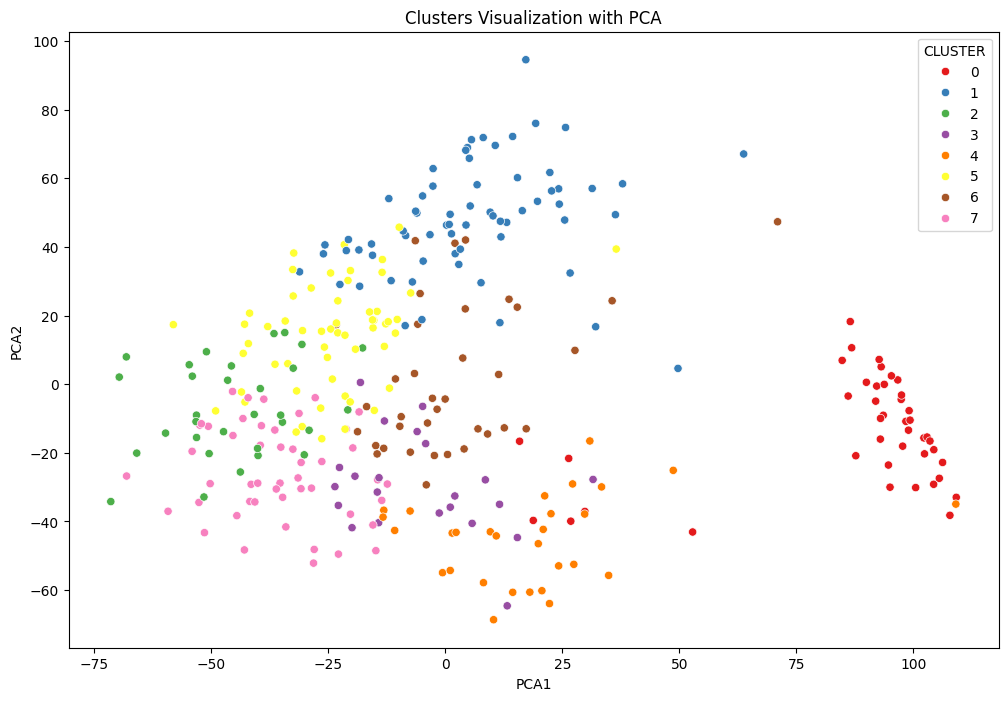

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns


# Assuming result17_18 is your final DataFrame with clustering results
# Perform PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(result16_17.drop(['PLAYER', 'TEAM', 'CLUSTER'], axis=1))

# Create a DataFrame with PCA results
pca_df = pd.DataFrame(pca_result, columns=['PCA1', 'PCA2'])
pca_df['CLUSTER'] = result16_17['CLUSTER']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='CLUSTER', palette='Set1', data=pca_df, legend='full')
plt.title('Clusters Visualization with PCA')
plt.show()

In [ ]:
# clusters.loc[:,['PLAYER', 'SILHOUETTE COEFFICIENT'] + col_names].sort_values(by=['SILHOUETTE COEFFICIENT'],ascending=False)

In [15]:
for i in range(8):
  print(f"CLUSTER {i}")
  print(result16_17.loc[result16_17['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
3             Alan Williams
6                  Alex Len
8             Alexis Ajinca
11           Andre Drummond
14             Andrew Bogut
19              Aron Baynes
24          Bismack Biyombo
30           Brandan Wright
45             Clint Capela
46              Cody Zeller
50        Cristiano Felicio
61                David Lee
63           DeAndre Jordan
77           Dewayne Dedmon
84            Dwight Howard
88                 Ed Davis
102    Georgios Papagiannis
109             Greg Monroe
111        Hassan Whiteside
113             Ian Mahinmi
119             Ivica Zubac
145             Joakim Noah
151             John Henson
155       Jonas Valanciunas
169            Jusuf Nurkic
175          Kenneth Faried
182            Kosta Koufos
197          Lucas Nogueira
204           Marcin Gortat
213           Mason Plumlee
229                    Nene
230            Nerlens Noel
239               Omer Asik
262             Robin Lopez
269             Rudy Gobert
286       

In [13]:
cols = [f'CLUSTER {i} DISTANCE' for i in range(8)]
cols = ['PLAYER', 'CLUSTER', 'SILHOUETTE COEFFICIENT'] + cols
result16_17.loc[:, cols]

,PLAYER,CLUSTER,SILHOUETTE COEFFICIENT,CLUSTER 0 DISTANCE,CLUSTER 1 DISTANCE,CLUSTER 2 DISTANCE,CLUSTER 3 DISTANCE,CLUSTER 4 DISTANCE,CLUSTER 5 DISTANCE,CLUSTER 6 DISTANCE,CLUSTER 7 DISTANCE
0,Aaron Gordon,6,0.101627,7.093345,5.813908,4.901471,3.823894,4.218415,3.213780,2.412195,3.803398
1,Al Horford,4,0.249116,7.367739,8.119964,6.943801,5.233957,3.058037,6.295787,5.353655,5.395914
2,Al-Farouq Aminu,7,0.314631,8.452929,7.192187,4.794602,4.519210,5.855352,4.252442,5.040458,1.931506
3,Alan Williams,0,0.345396,3.505499,11.790046,11.934299,7.279228,7.225022,11.066165,9.627212,10.077948
4,Alec Burks,6,-0.009512,8.778319,4.750677,5.153415,5.507516,6.180653,2.813010,2.671603,4.956683
...,...,...,...,...,...,...,...,...,...,...,...
325,Wilson Chandler,6,0.136178,7.755857,5.499910,5.052634,4.628416,4.458139,3.195536,2.129216,4.020848
326,Yogi Ferrell,1,0.350072,11.315138,2.468400,7.955058,9.025137,9.095763,5.294591,5.949957,8.087594
327,Zach LaVine,5,0.146717,10.351815,5.599470,5.209005,7.694913,7.840331,3.672288,4.639886,6.602632
328,Zach Randolph,4,0.314257,5.817616,8.943348,9.046415,5.189055,2.524777,7.917116,5.570008,7.289127


# 2015-2016 Season Clusters

In [ ]:
pd.set_option('display.max_rows', None)  # Display all rows
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', None)  # Display full width

for i in range(8):
  print(f"CLUSTER {i}")
  print(result16_17.loc[result16_17['CLUSTER'] == i, 'PLAYER'])
  print()

CLUSTER 0
20                Arron Afflalo
22                Avery Bradley
29                 Bradley Beal
36                  Buddy Hield
37                  C.J. Watson
40                 Caris LeVert
42             Chandler Parsons
49                 Courtney Lee
54             Danilo Gallinari
57                   Dante Exum
76                 Devin Harris
87                E'Twaun Moore
93                  Eric Gordon
95                Evan Fournier
98               Garrett Temple
99                  Gary Harris
103            Gerald Henderson
114               Iman Shumpert
115               Isaiah Canaan
128                Jamal Murray
142                Jerian Grant
148                  Joe Ingles
158             Jordan Crawford
159               Jordan Farmar
162             Josh Richardson
176               Kent Bazemore
177    Kentavious Caldwell-Pope
192           Langston Galloway
202               Manu Ginobili
207                Marcus Smart
208             Marcus Thornto